In [1]:
#import tensorflow as tf 
# https://sci-hub.se/10.1002/sim.1203
# https://journals.sagepub.com/doi/pdf/10.1177/1536867x0900900206

# Dataset

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 

from sksurv.metrics import concordance_index_censored
from lifelines.datasets import load_rossi

data = load_rossi()
data.dropna(inplace=True)
print(data.shape)
data.head()

(432, 9)


,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


In [3]:
event_col = "arrest"
duration_col = "week"

X = data.drop(columns=[event_col, duration_col])
X.shape

(432, 7)

# Train-test split

In [4]:
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(
    range(data.shape[0]), test_size=0.15, random_state=42, stratify=data[event_col]
)
# Data splits
data_train, data_test = data.iloc[train_idx], data.iloc[test_idx]
print(data_train.shape, data_test.shape)

# Feature matrix splits 
X_train, X_test = X.iloc[train_idx].values, X.iloc[test_idx].values

(367, 9) (65, 9)


# Pre-processing

In [5]:
from sksurv.util import Surv

event_test = data_test[event_col].values
event_train = data_train[event_col].values

duration_test = data_test[duration_col].values
duration_train = data_train[duration_col].values

y_test = Surv.from_arrays(event=event_test.squeeze(), time=duration_test.squeeze())
y_train = Surv.from_arrays(event=event_train.squeeze(), time=duration_train.squeeze())

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model fitting

In [7]:
from utils.model import Model

model = Model(epochs=1)
model.fit(X_train, y_train)

# Coefficient at initialization 
from utils.data import init_params_cox, init_params_random
beta, _ = init_params_cox(model.D, X_train, duration_train, event_train)
#beta, _ = init_params_random(model.D, X_train, duration_train, event_train)

# Baseline 
print(concordance_index_censored(event_train.astype(bool), duration_train, (X_train @ beta.T).squeeze()))
print(concordance_index_censored(event_test.astype(bool), duration_test, (X_test @ beta.T).squeeze()))

2025-04-22 08:01:33.948390: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(0.6364301271007379, 19561, 11167, 35, 1080)
(0.6377497371188223, 606, 344, 1, 0)


In [8]:
model = Model(epochs=500, learning_rate=0.01, alpha=10, l1_ratio=0)
model.fit(X_train, y_train)

print(model.gamma.squeeze())
print(model.beta.squeeze())

# Fitted model 
print(concordance_index_censored(event_train.astype(bool), duration_train, model.risk_score(X_train).squeeze()))
print(concordance_index_censored(event_test.astype(bool), duration_test, model.risk_score(X_test).squeeze()))

[-1.6385839 -1.3417188  0.6312399  3.0771575]
[-0.07851909 -0.06506102  0.04337979 -0.03525626 -0.06878184  0.00143166
  0.15083489]
(0.6425738712089198, 19750, 10978, 35, 1080)
(0.6156677181913774, 585, 365, 1, 0)


# Estimates 

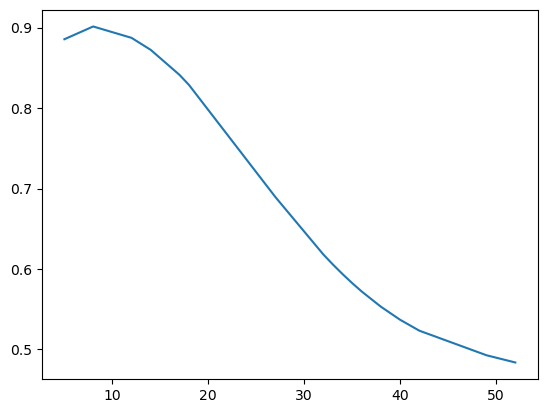

In [9]:
Sb = model.baseline_survival(duration_test)
idx = np.argsort(duration_test)
plt.figure()
plt.plot(duration_test[idx], Sb[idx, 0])

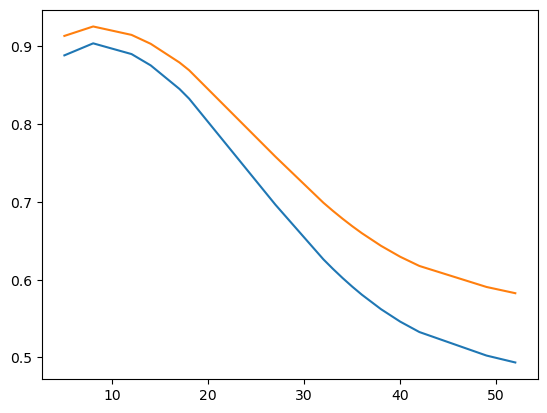

In [10]:
S0 = model.survival_curve(X_test[0], duration_test)
S1 = model.survival_curve(X_test[1], duration_test)

plt.figure()
idx = np.argsort(duration_test)
plt.plot(duration_test[idx], S0[idx, 0])
plt.plot(duration_test[idx], S1[idx, 0])